<a href="https://colab.research.google.com/github/Gioalf/AH2179/blob/main/project/AIprojectGioAlf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PUBLIC TRANSPORT PROJECT
The project will be divided into two parts, in both cases I will create models that estimate the arrival delay at different stages of the trip:\
* **Part A** will have limited available data, it will be missing all the real time data such as `upstream_stop_delay`, `previous_bus_delay`, `previous_trip_travel_time`, `recurrent_delay` and `travel_time_for_previous_section`

* **Part B** will have all the available data that will lead to a more accurate prediction.

### METHOD
I will use different methods to create prediction models and obtain the best predictions possible, I will then likely use the best model I can get to predict the delays and then check the accuracy of them.\
I can also maybe do some feature engineering and use day of the week and stuff like that.

## DATA HANDLING
Here I will import the dataset and clean it to make it easier to use for my purposes

In [1]:
%pip install pandasql
import pandas as pd
import numpy as np
import pandasql
from pandasql import sqldf

url = 'https://raw.githubusercontent.com/zhenliangma/Applied-AI-in-Transportation/master/ProjectAssignmentData/Dataset-PT.csv'
df = pd.read_csv(url, skiprows=1, header=0)

display(df.head())

  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26773 sha256=0b0f9ebec1976e53fdb0f5e1844cc7c1217b06c41eeab86ad7de3deb9625cf4e
  Stored in directory: /root/.cache/pip/wheels/15/a1/e7/6f92f295b5272ae5c02365e6b8fa19cb93f16a537090a1cf27
Successfully built pandasql


,Calendar_date,route_id,bus_id,stop_sequence,arrival_delay,dwell_time,travel_time_for_previous_section,scheduled_travel_time,upstream_stop_delay,origin_delay,...,factor(weather)Rain,factor(weather)Snow,factor(temperature)Cold,factor(temperature)Extra_cold,factor(temperature)Normal,factor(day_of_week)weekday,factor(day_of_week)weekend,factor(time_of_day)Afternoon_peak,factor(time_of_day)Morning_peak,factor(time_of_day)Off-peak
0,20220108,4,41344,1,151,0,0,120,100,100,...,0,0,0,0,1,0,1,0,0,1
1,20220108,4,41344,2,185,24,171,45,151,100,...,0,0,0,0,1,0,1,0,0,1
2,20220108,4,41344,3,186,0,55,41,185,100,...,0,0,0,0,1,0,1,0,0,1
3,20220108,4,41344,4,202,12,42,94,186,100,...,0,0,0,0,1,0,1,0,0,1
4,20220108,4,41344,5,242,21,98,86,202,100,...,0,0,0,0,1,0,1,0,0,1


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545103 entries, 0 to 545102
Data columns (total 31 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Calendar_date                      545103 non-null  int64  
 1   route_id                           545103 non-null  int64  
 2   bus_id                             545103 non-null  int64  
 3   stop_sequence                      545103 non-null  int64  
 4   arrival_delay                      545103 non-null  int64  
 5   dwell_time                         545103 non-null  int64  
 6   travel_time_for_previous_section   545103 non-null  int64  
 7   scheduled_travel_time              545103 non-null  int64  
 8   upstream_stop_delay                545103 non-null  int64  
 9   origin_delay                       545103 non-null  int64  
 10  previous_bus_delay                 545103 non-null  int64  
 11  previous_trip_travel_time          5451

I noticed that with the current data I can't associate each row with a specific trip but only with a date and vehicle, so I will add that feature in the most trivial way by just adding a column with a sequential number for each trip.

In [3]:
def trip_counter(group):
    # create a counter that increases every 27 rows
    n_rows = len(group)
    group['trip_number'] = np.arange(n_rows) // 27 + 1
    return group

df = df.groupby('Calendar_date').apply(trip_counter).reset_index(drop=True)

/tmp/ipython-input-3494565459.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Calendar_date').apply(trip_counter).reset_index(drop=True)


In [4]:
df

,Calendar_date,route_id,bus_id,stop_sequence,arrival_delay,dwell_time,travel_time_for_previous_section,scheduled_travel_time,upstream_stop_delay,origin_delay,...,factor(weather)Snow,factor(temperature)Cold,factor(temperature)Extra_cold,factor(temperature)Normal,factor(day_of_week)weekday,factor(day_of_week)weekend,factor(time_of_day)Afternoon_peak,factor(time_of_day)Morning_peak,factor(time_of_day)Off-peak,trip_number
0,20220108,4,41344,1,151,0,0,120,100,100,...,0,0,0,1,0,1,0,0,1,1
1,20220108,4,41344,2,185,24,171,45,151,100,...,0,0,0,1,0,1,0,0,1,1
2,20220108,4,41344,3,186,0,55,41,185,100,...,0,0,0,1,0,1,0,0,1,1
3,20220108,4,41344,4,202,12,42,94,186,100,...,0,0,0,1,0,1,0,0,1,1
4,20220108,4,41344,5,242,21,98,86,202,100,...,0,0,0,1,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545098,20220630,4,41362,23,344,13,74,44,341,12,...,0,0,0,1,1,0,0,0,1,50
545099,20220630,4,41362,24,330,15,34,92,344,12,...,0,0,0,1,1,0,0,0,1,50
545100,20220630,4,41362,25,339,17,63,43,330,12,...,0,0,0,1,1,0,0,0,1,50
545101,20220630,4,41362,26,331,0,35,58,339,12,...,0,0,0,1,1,0,0,0,1,50


In [5]:
 # checking that there is only 27 rows to each date-trip pair so that I didn't make mistakes in the cleaning process
(df.groupby(['Calendar_date', 'trip_number']).size().reset_index(name='count'))['count'].unique()

array([27])

In [6]:
# query = "SELECT DISTINCT Calendar_date, MAX(trip_number) FROM df GROUP BY Calendar_date"
# sqldf(query)

Trying to get some insights and ideas from the data I have

Average Arrival Delay by Stop Sequence:


,stop_sequence,arrival_delay
0,1,63.961117
1,2,100.140274
2,3,92.829660
3,4,65.273961
4,5,107.407251
5,6,138.431671
6,7,128.251226
7,8,106.233593
8,9,136.354797
9,10,161.177473


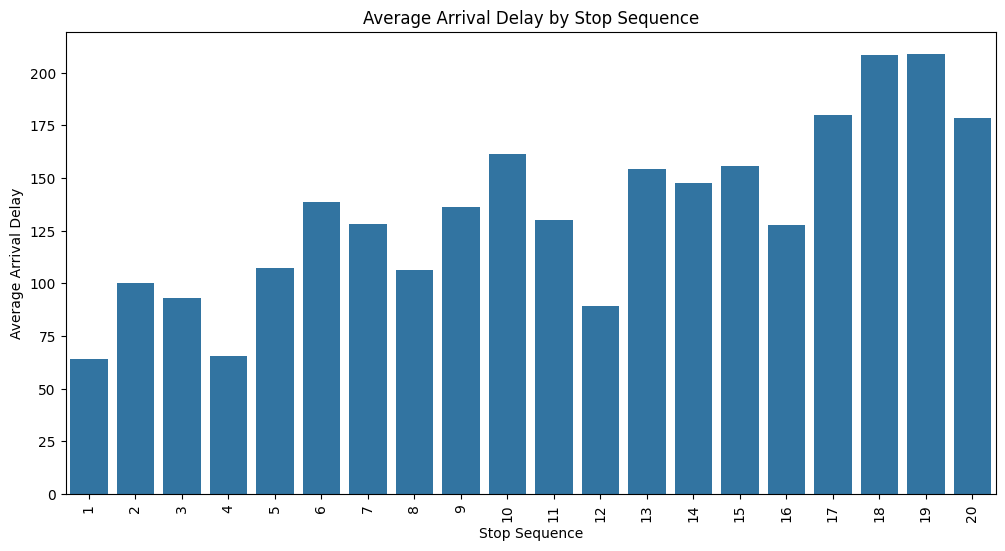

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the average arrival delay for each stop sequence
average_delay_by_stop = df.groupby('stop_sequence')['arrival_delay'].mean().reset_index()[:20]

# Display the average arrival delay for each stop sequence
print("Average Arrival Delay by Stop Sequence:")
display(average_delay_by_stop)

# Optional: You can still visualize this data if you'd like, for example, with a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=average_delay_by_stop, x='stop_sequence', y='arrival_delay')
plt.title('Average Arrival Delay by Stop Sequence')
plt.xlabel('Stop Sequence')
plt.ylabel('Average Arrival Delay')
plt.xticks(rotation=90)
plt.show()

In [8]:
df.head(25)

,Calendar_date,route_id,bus_id,stop_sequence,arrival_delay,dwell_time,travel_time_for_previous_section,scheduled_travel_time,upstream_stop_delay,origin_delay,...,factor(weather)Snow,factor(temperature)Cold,factor(temperature)Extra_cold,factor(temperature)Normal,factor(day_of_week)weekday,factor(day_of_week)weekend,factor(time_of_day)Afternoon_peak,factor(time_of_day)Morning_peak,factor(time_of_day)Off-peak,trip_number
0,20220108,4,41344,1,151,0,0,120,100,100,...,0,0,0,1,0,1,0,0,1,1
1,20220108,4,41344,2,185,24,171,45,151,100,...,0,0,0,1,0,1,0,0,1,1
2,20220108,4,41344,3,186,0,55,41,185,100,...,0,0,0,1,0,1,0,0,1,1
3,20220108,4,41344,4,202,12,42,94,186,100,...,0,0,0,1,0,1,0,0,1,1
4,20220108,4,41344,5,242,21,98,86,202,100,...,0,0,0,1,0,1,0,0,1,1
5,20220108,4,41344,6,260,13,105,38,242,100,...,0,0,0,1,0,1,0,0,1,1
6,20220108,4,41344,7,278,12,43,79,260,100,...,0,0,0,1,0,1,0,0,1,1
7,20220108,4,41344,8,272,8,85,97,278,100,...,0,0,0,1,0,1,0,0,1,1
8,20220108,4,41344,9,292,24,83,47,272,100,...,0,0,0,1,0,1,0,0,1,1
9,20220108,4,41344,10,351,9,43,85,292,100,...,0,0,0,1,0,1,0,0,1,1


Average Arrival Delay by Stop Sequence and Time of Day:


,stop_sequence,time_of_day,arrival_delay
0,1,AP,54.393781
1,1,MP,34.141484
2,1,OP,74.997470
3,2,AP,93.186565
4,2,MP,61.530490
...,...,...,...
76,26,MP,106.254130
77,26,OP,172.395983
78,27,AP,-23.506765
79,27,MP,19.576449


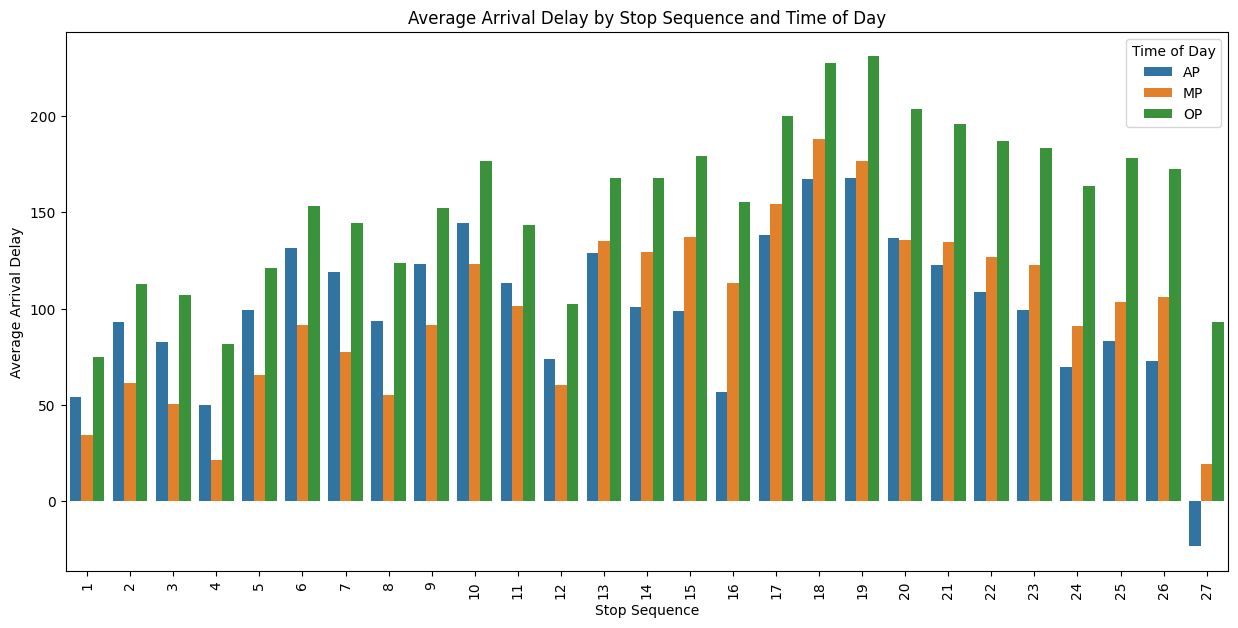

In [9]:
# Calculate the average arrival delay for each stop sequence and time of day
average_delay_by_stop_and_time = df.groupby(['stop_sequence', 'time_of_day'])['arrival_delay'].mean().reset_index()

# Display the average arrival delay by stop sequence and time of day
print("Average Arrival Delay by Stop Sequence and Time of Day:")
display(average_delay_by_stop_and_time)

# Visualize the average arrival delay by stop sequence and time of day using a grouped bar plot
plt.figure(figsize=(15, 7))
sns.barplot(data=average_delay_by_stop_and_time, x='stop_sequence', y='arrival_delay', hue='time_of_day')
plt.title('Average Arrival Delay by Stop Sequence and Time of Day')
plt.xlabel('Stop Sequence')
plt.ylabel('Average Arrival Delay')
plt.xticks(rotation=90)
plt.legend(title='Time of Day')
plt.show()

In [10]:
# Calculate the average arrival delay for each stop sequence and time of day first
average_delay_by_stop_and_time = df.groupby(['stop_sequence', 'time_of_day'])['arrival_delay'].mean().reset_index()

# Now calculate the standard deviation of these average delays for each stop sequence
std_of_average_delay_by_stop = average_delay_by_stop_and_time.groupby('stop_sequence')['arrival_delay'].std().reset_index()

# Display the standard deviation of the average arrival delay by stop sequence
print("Standard Deviation of Average Arrival Delay Across Time of Day for Each Stop Sequence:")
display(std_of_average_delay_by_stop)

Standard Deviation of Average Arrival Delay Across Time of Day for Each Stop Sequence:


,stop_sequence,arrival_delay
0,1,20.428245
1,2,25.787169
2,3,28.469313
3,4,30.210727
4,5,27.900489
5,6,31.228323
6,7,34.022809
7,8,34.500700
8,9,30.368215
9,10,26.782627


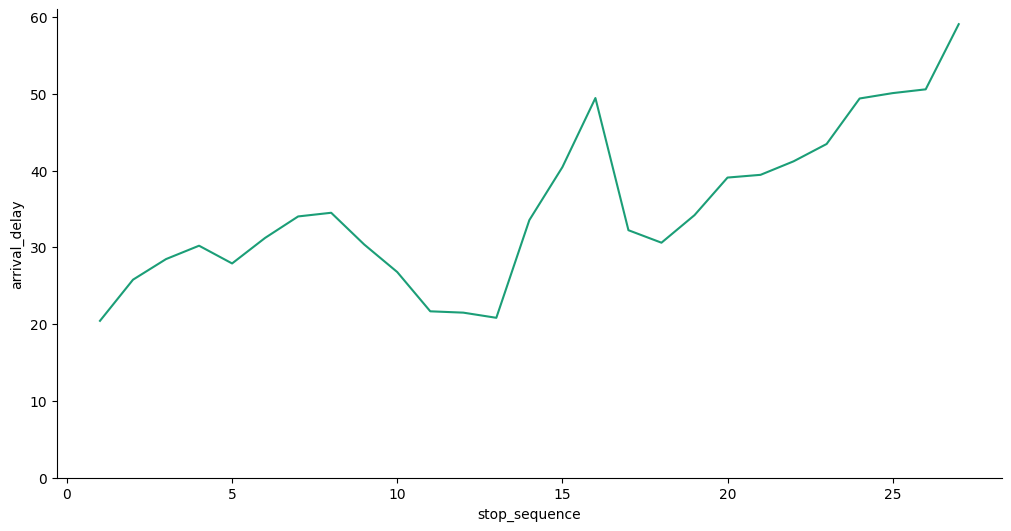

In [11]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['stop_sequence']
  ys = series['arrival_delay']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = std_of_average_delay_by_stop.sort_values('stop_sequence', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('stop_sequence')
_ = plt.ylabel('arrival_delay')
plt.ylim(bottom=0) # Set the y-axis to start from 0
plt.show()

## PART A
I will get rid of some of the features that are only available in real time, i.e: `upstream_stop_delay`, `previous_bus_delay`, `previous_trip_travel_time`, `recurrent_delay`, and `travel_time_for_previous_section`

In [51]:
dfA=df.drop(['upstream_stop_delay', 'previous_bus_delay', 'previous_trip_travel_time', 'recurrent_delay', 'travel_time_for_previous_section'], axis=1)

In [52]:
dfA

,Calendar_date,route_id,bus_id,stop_sequence,arrival_delay,dwell_time,scheduled_travel_time,origin_delay,traffic_condition,weather,...,factor(weather)Snow,factor(temperature)Cold,factor(temperature)Extra_cold,factor(temperature)Normal,factor(day_of_week)weekday,factor(day_of_week)weekend,factor(time_of_day)Afternoon_peak,factor(time_of_day)Morning_peak,factor(time_of_day)Off-peak,trip_number
0,20220108,4,41344,1,151,0,120,100,168.666667,Light Snow,...,0,0,0,1,0,1,0,0,1,1
1,20220108,4,41344,2,185,24,45,100,46.333333,Light Snow,...,0,0,0,1,0,1,0,0,1,1
2,20220108,4,41344,3,186,0,41,100,36.666667,Light Snow,...,0,0,0,1,0,1,0,0,1,1
3,20220108,4,41344,4,202,12,94,100,88.000000,Light Snow,...,0,0,0,1,0,1,0,0,1,1
4,20220108,4,41344,5,242,21,86,100,102.000000,Light Snow,...,0,0,0,1,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545098,20220630,4,41362,23,344,13,44,12,32.666667,Normal,...,0,0,0,1,1,0,0,0,1,50
545099,20220630,4,41362,24,330,15,92,12,77.000000,Normal,...,0,0,0,1,1,0,0,0,1,50
545100,20220630,4,41362,25,339,17,43,12,38.000000,Normal,...,0,0,0,1,1,0,0,0,1,50
545101,20220630,4,41362,26,331,0,58,12,50.666667,Normal,...,0,0,0,1,1,0,0,0,1,50


In [53]:
dfA_clean=dfA.copy()

### **MODEL 1 General Linear Regression**

In this model I will try to do a linear regression on the whole dataset to see what comes out.\
I will add the arrival delay at stop 20 of each run to every row of that run to be used as the target.\
I assume this will perform poorly as it is a huge training of the whole dataset and I will test it from specific stop numbers. I'm not even sure it will run, and also I think it might leak data since I use delays from stops that are further away.

In [54]:
# Filter for rows where stop_sequence is 20
delay_at_stop_20 = dfA_clean[dfA_clean['stop_sequence'] == 20][['Calendar_date', 'trip_number', 'arrival_delay']]

# Rename the 'arrival_delay' column to indicate it's the delay at stop 20
delay_at_stop_20 = delay_at_stop_20.rename(columns={'arrival_delay': 'arrival_delay_stop_20'})

# Merge this information back into dfA_clean
dfA_clean = pd.merge(dfA_clean, delay_at_stop_20, on=['Calendar_date', 'trip_number'], how='left')

# Display the updated DataFrame
dfA_clean



,Calendar_date,route_id,bus_id,stop_sequence,arrival_delay,dwell_time,scheduled_travel_time,origin_delay,traffic_condition,weather,...,factor(temperature)Cold,factor(temperature)Extra_cold,factor(temperature)Normal,factor(day_of_week)weekday,factor(day_of_week)weekend,factor(time_of_day)Afternoon_peak,factor(time_of_day)Morning_peak,factor(time_of_day)Off-peak,trip_number,arrival_delay_stop_20
0,20220108,4,41344,1,151,0,120,100,168.666667,Light Snow,...,0,0,1,0,1,0,0,1,1,419
1,20220108,4,41344,2,185,24,45,100,46.333333,Light Snow,...,0,0,1,0,1,0,0,1,1,419
2,20220108,4,41344,3,186,0,41,100,36.666667,Light Snow,...,0,0,1,0,1,0,0,1,1,419
3,20220108,4,41344,4,202,12,94,100,88.000000,Light Snow,...,0,0,1,0,1,0,0,1,1,419
4,20220108,4,41344,5,242,21,86,100,102.000000,Light Snow,...,0,0,1,0,1,0,0,1,1,419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545098,20220630,4,41362,23,344,13,44,12,32.666667,Normal,...,0,0,1,1,0,0,0,1,50,274
545099,20220630,4,41362,24,330,15,92,12,77.000000,Normal,...,0,0,1,1,0,0,0,1,50,274
545100,20220630,4,41362,25,339,17,43,12,38.000000,Normal,...,0,0,1,1,0,0,0,1,50,274
545101,20220630,4,41362,26,331,0,58,12,50.666667,Normal,...,0,0,1,1,0,0,0,1,50,274


Now I can remove the unwanted columns of the df

In [55]:
dfA_clean.columns

Index(['Calendar_date', 'route_id', 'bus_id', 'stop_sequence', 'arrival_delay',
       'dwell_time', 'scheduled_travel_time', 'origin_delay',
       'traffic_condition', 'weather', 'temperature', 'day_of_week',
       'time_of_day', 'factor(weather)Light_Rain', 'factor(weather)Light_Snow',
       'factor(weather)Normal', 'factor(weather)Rain', 'factor(weather)Snow',
       'factor(temperature)Cold', 'factor(temperature)Extra_cold',
       'factor(temperature)Normal', 'factor(day_of_week)weekday',
       'factor(day_of_week)weekend', 'factor(time_of_day)Afternoon_peak',
       'factor(time_of_day)Morning_peak', 'factor(time_of_day)Off-peak',
       'trip_number', 'arrival_delay_stop_20'],
      dtype='object')

In [56]:
dfA_clean=dfA_clean.drop(['route_id', 'bus_id', 'weather', 'temperature', 'day_of_week',
       'time_of_day', 'trip_number'], axis=1)

In [57]:
dfA_model1=dfA_clean.copy()
dfA_model1=dfA_model1[dfA_model1['stop_sequence']!=20]

In [58]:
dfA_model1

,Calendar_date,stop_sequence,arrival_delay,dwell_time,scheduled_travel_time,origin_delay,traffic_condition,factor(weather)Light_Rain,factor(weather)Light_Snow,factor(weather)Normal,...,factor(weather)Snow,factor(temperature)Cold,factor(temperature)Extra_cold,factor(temperature)Normal,factor(day_of_week)weekday,factor(day_of_week)weekend,factor(time_of_day)Afternoon_peak,factor(time_of_day)Morning_peak,factor(time_of_day)Off-peak,arrival_delay_stop_20
0,20220108,1,151,0,120,100,168.666667,0,1,0,...,0,0,0,1,0,1,0,0,1,419
1,20220108,2,185,24,45,100,46.333333,0,1,0,...,0,0,0,1,0,1,0,0,1,419
2,20220108,3,186,0,41,100,36.666667,0,1,0,...,0,0,0,1,0,1,0,0,1,419
3,20220108,4,202,12,94,100,88.000000,0,1,0,...,0,0,0,1,0,1,0,0,1,419
4,20220108,5,242,21,86,100,102.000000,0,1,0,...,0,0,0,1,0,1,0,0,1,419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545098,20220630,23,344,13,44,12,32.666667,0,0,1,...,0,0,0,1,1,0,0,0,1,274
545099,20220630,24,330,15,92,12,77.000000,0,0,1,...,0,0,0,1,1,0,0,0,1,274
545100,20220630,25,339,17,43,12,38.000000,0,0,1,...,0,0,0,1,1,0,0,0,1,274
545101,20220630,26,331,0,58,12,50.666667,0,0,1,...,0,0,0,1,1,0,0,0,1,274


In [59]:
# import seaborn as sns
# sns.pairplot(dfA_model1[['stop_sequence','arrival_delay',
#        'dwell_time', 'scheduled_travel_time', 'origin_delay',
#        'traffic_condition', 'arrival_delay_stop_20']])

The plots shown above show the potential correlations between each of the factors and also the target feature. We can see that there is an obvious quite-linear correlation between the `arrival_delay`, `origin_delay`, and `arrival_delay_stop_20`, these will probably play a huge role in predicting the value I need.

In [60]:
corr_matrix = dfA_model1.corr()
corr_matrix['arrival_delay_stop_20'].sort_values(ascending=False)

,arrival_delay_stop_20
arrival_delay_stop_20,1.000000e+00
arrival_delay,8.754289e-01
origin_delay,6.698564e-01
factor(day_of_week)weekend,1.899610e-01
factor(time_of_day)Off-peak,1.562884e-01
Calendar_date,1.433879e-01
dwell_time,5.179801e-02
factor(temperature)Normal,3.445202e-02
factor(weather)Normal,2.410104e-02
factor(weather)Rain,9.951747e-03


**I will now define the train data which is going to be 80% of the df then I will test it on different hypothesis**

In [87]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

x = dfA_model1.drop(['arrival_delay_stop_20'], axis=1)
y = dfA_model1['arrival_delay_stop_20']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [88]:
# Create a Linear Regression model
model1 = LinearRegression()

# Fit the model to the training data
model1.fit(X_train_scaled, y_train)

# Predict the test data with the fitted model
y_pred_A1_0 = model1.predict(X_test_scaled)

In [81]:
# Get the coefficients and the feature names
coefficients = model1.coef_
feature_names = X_train.columns

# Create a pandas Series to easily view coefficients with their feature names
coefficients_series = pd.Series(coefficients, index=feature_names)

# Sort the coefficients by their absolute value to see the most influential features
sorted_coefficients = coefficients_series.abs().sort_values(ascending=False)

print("Model Coefficients (sorted by absolute value):")
display(coefficients_series[sorted_coefficients.index])

Model Coefficients (sorted by absolute value):


,0
arrival_delay,179.220476
scheduled_travel_time,27.037494
stop_sequence,-16.844133
traffic_condition,-16.024604
origin_delay,9.785216
Calendar_date,5.163107
dwell_time,-5.078804
factor(time_of_day)Off-peak,4.679610
factor(time_of_day)Afternoon_peak,-3.672733
factor(time_of_day)Morning_peak,-2.078498


In [82]:
mae = mean_absolute_error(y_test, y_pred_A1_0)
mse = mean_squared_error(y_test, y_pred_A1_0)
r2 = r2_score(y_test, y_pred_A1_0)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Absolute Error: 69.60612604929483
Mean Squared Error: 9564.049456298508
R-squared: 0.7806411417899002


**Testing on all stops**\
Now I will try to use some of the test data, specifically the data collected in the rows related to all specific stops


In [89]:
evaluation_results = []

for stop_seq in range(1, 20):  # Loop from stop_sequence 1 to 19 (exclusive of 20)
    # Filter the test data for the current stop sequence
    X_test_seq = X_test[X_test['stop_sequence'] == stop_seq]
    y_test_seq = y_test.loc[X_test_seq.index]

    # Check if there are samples for the current stop sequence
    if not X_test_seq.empty:
        # Normalize the features using the scaler fitted on the training data
        X_test_scaled_seq = scaler.transform(X_test_seq)

        # Predict the test data with the fitted model
        y_pred_seq = model1.predict(X_test_scaled_seq)

        # Calculate evaluation metrics
        mae = mean_absolute_error(y_test_seq, y_pred_seq)
        mse = mean_squared_error(y_test_seq, y_pred_seq)
        r2 = r2_score(y_test_seq, y_pred_seq)

        # Store the results in a dictionary
        results = {
            'stop_sequence': stop_seq,
            'MAE': mae,
            'MSE': mse,
            'R-squared': r2
        }
        evaluation_results.append(results)
    else:
        print(f"No test samples for stop sequence {stop_seq}")

# Convert the list of dictionaries to a DataFrame for better viewing
evaluation_df = pd.DataFrame(evaluation_results)

# Display the results
print("Evaluation Metrics by Stop Sequence (1 to 19):")
display(evaluation_df)

Evaluation Metrics by Stop Sequence (1 to 19):


,stop_sequence,MAE,MSE,R-squared
0,1,112.448432,22449.646378,0.479009
1,2,107.097240,19998.323194,0.543181
2,3,105.596833,21500.603495,0.494483
3,4,103.918597,19743.881227,0.592520
4,5,96.018527,15858.740788,0.627645
5,6,93.796953,15698.219789,0.638287
6,7,94.209344,14892.626223,0.655071
7,8,90.323189,13994.894736,0.675087
8,9,86.587691,13710.753953,0.669056
9,10,86.704280,13376.763264,0.687928


In [90]:
model_1_y_pred_19=y_pred_seq
model_1_y_test_19=y_test_seq

### **MODEL 2 Linear Regression on single stops**
In this other case I will try to make multiple models that will only be trained from a specific stop, I will try with linear regression again and if it looks promising I will improve on it

I will now divide the df into smaller df that only contain rows from a specific stop

In [67]:
dfA_model2=dfA_clean.copy()

In [85]:
from sklearn.model_selection import TimeSeriesSplit

df2 = {}
models2 = {}
test_train2={}
results2 = {}
predictions2 = {}

for i in range(1, 21):
    # Filter data for this stop
    dfA_model2_i = dfA_model2[dfA_model2['stop_sequence'] == i].copy()
    df2[f'stop_{i}'] = dfA_model2_i

    # Drop non-predictive columns
    dfA_model2_i = dfA_model2_i.drop(['Calendar_date', 'stop_sequence'], axis=1)

    # Define features and target
    X = dfA_model2_i.drop(['arrival_delay_stop_20'], axis=1)
    y = dfA_model2_i['arrival_delay_stop_20']

    # Split chronologically: first 80% train, last 20% test
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    test_train2[f'stop_{i}'] = {'X_train_scaled': X_train_scaled, 'X_test_scaled': X_test_scaled, 'y_train': y_train, 'y_test': y_test}

    # Train model
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)

    # Evaluate on the test set
    y_pred = model.predict(X_test_scaled)
    predictions2[f'stop_{i}'] = y_pred
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    # Store results
    models2[f'model_stop_{i}'] = model
    results2[f'stop_{i}'] = {'R2': r2, 'MAE': mae, 'MSE': mse}

# Display performance summary
pd.DataFrame(results2).T



,R2,MAE,MSE
stop_1,0.636019,1.185766e+02,2.424213e+04
stop_2,0.671589,1.136772e+02,2.187307e+04
stop_3,0.682295,1.121373e+02,2.116001e+04
stop_4,0.708166,1.078206e+02,1.943694e+04
stop_5,0.742939,1.012861e+02,1.712099e+04
stop_6,0.756807,9.873222e+01,1.619732e+04
stop_7,0.769776,9.609976e+01,1.533357e+04
stop_8,0.779971,9.391706e+01,1.465456e+04
stop_9,0.794951,9.020748e+01,1.365681e+04
stop_10,0.802046,8.826342e+01,1.318428e+04


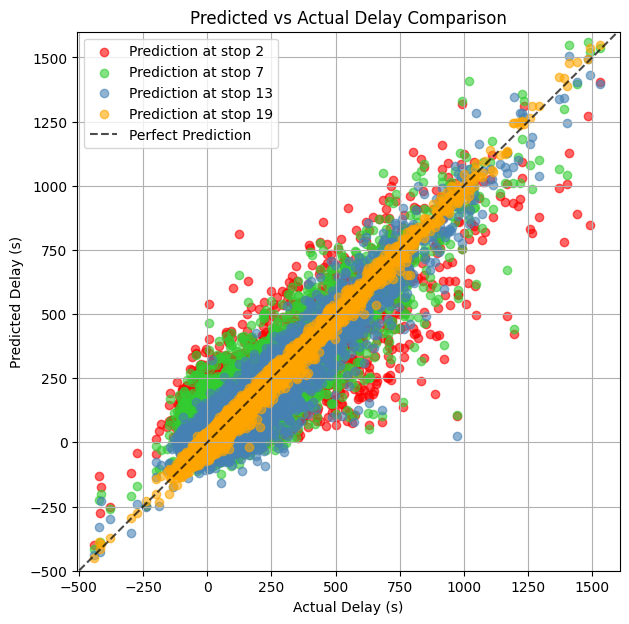

In [107]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(7,7))

# Scatter 0
plt.scatter(test_train2['stop_2']['y_test'], predictions2['stop_2'], alpha=0.6, label='Prediction at stop 2', color='red')

# Scatter 1
plt.scatter(test_train2['stop_7']['y_test'], predictions2['stop_7'], alpha=0.6, label='Prediction at stop 7', color='limegreen')

# Scatter 2
plt.scatter(test_train2['stop_13']['y_test'], predictions2['stop_14'], alpha=0.6, label='Prediction at stop 13', color='steelblue')

# Scatter 3
plt.scatter(test_train2['stop_19']['y_test'], predictions2['stop_19'], alpha=0.6, label='Prediction at stop 19', color='orange')


# Diagonal line (perfect prediction)
lims = [
    np.min([plt.xlim()[0], plt.ylim()[0]]),
    np.max([plt.xlim()[1], plt.ylim()[1]])
]
plt.plot(lims, lims, 'k--', alpha=0.7, label='Perfect Prediction')

# Labels, legend, limits
plt.xlabel('Actual Delay (s)')
plt.ylabel('Predicted Delay (s)')
plt.title('Predicted vs Actual Delay Comparison')
plt.legend()
plt.grid(True)
plt.axis('equal')

# Limit axes
plt.xlim(-500, 1600)
plt.ylim(-500, 1600)

plt.show()


Random plot of expected vs actual values for a specific stop

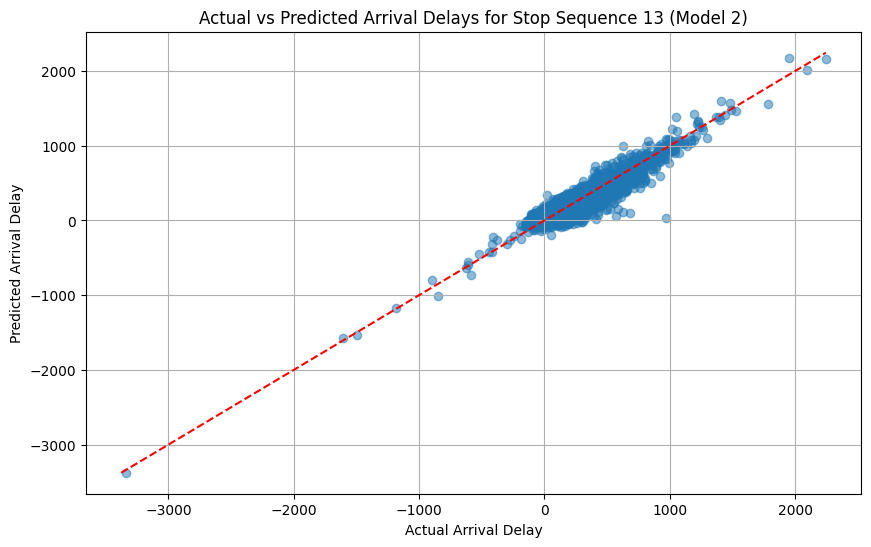

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Get the scaled test data and true values for stop 13 from the test_train2 dictionary
X_test_scaled_stop13 = test_train2['stop_13']['X_test_scaled']
y_test_stop13 = test_train2['stop_13']['y_test']

# Get the trained model for stop 13 from the models2 dictionary
model_stop13 = models2['model_stop_13']

# Make predictions on the scaled test set for stop 13
y_pred_stop13 = model_stop13.predict(X_test_scaled_stop13)

# Create a scatter plot of actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_stop13, y_pred_stop13, alpha=0.5)

# Add a diagonal line
max_val = max(y_test_stop13.max(), y_pred_stop13.max())
min_val = min(y_test_stop13.min(), y_pred_stop13.min())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')


plt.title('Actual vs Predicted Arrival Delays for Stop Sequence 13 (Model 2)')
plt.xlabel('Actual Arrival Delay')
plt.ylabel('Predicted Arrival Delay')
plt.grid(True)
plt.show()

In [ ]:
# Get the coefficients and the feature names
coefficients = models2['model_stop_18'].coef_
feature_names = X_train.columns

# Create a pandas Series to easily view coefficients with their feature names
coefficients_series = pd.Series(coefficients, index=feature_names)

# Sort the coefficients by their absolute value to see the most influential features
sorted_coefficients = coefficients_series.abs().sort_values(ascending=False)

print("Model Coefficients (sorted by absolute value):")
display(coefficients_series[sorted_coefficients.index])

Model Coefficients (sorted by absolute value):


,0
arrival_delay,193.176882
scheduled_travel_time,-9.008840
factor(time_of_day)Morning_peak,-5.085273
factor(day_of_week)weekday,3.525778
factor(day_of_week)weekend,-3.525778
factor(time_of_day)Off-peak,3.136529
origin_delay,-2.797711
factor(temperature)Extra_cold,-0.929912
factor(time_of_day)Afternoon_peak,0.924084
traffic_condition,0.865926


### **MODEL 3 XGBoost on single stops**
Now I'll try to do the same with XGBoost as the model to compare performance.

In [109]:
# !pip install xgboost

In [110]:
dfA_model3=dfA_clean.copy()

In [111]:
from xgboost import XGBRegressor

df3 = {}
models3 = {}
results3 = {}

for i in range(1, 21):
    # Filter data for this stop
    dfA_model3_i = dfA_model3[dfA_model3['stop_sequence'] == i].copy()
    df3[f'stop_{i}'] = dfA_model3_i

    # Drop non-predictive columns
    dfA_model3_i = dfA_model3_i.drop(['Calendar_date', 'stop_sequence'], axis=1)

    # Define features and target
    X = dfA_model3_i.drop(['arrival_delay_stop_20'], axis=1)
    y = dfA_model3_i['arrival_delay_stop_20']

    # Split chronologically: first 80% train, last 20% test
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train XGBoost model
    model = XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        subsample=0.8,
        colsample_bytree=1,
        random_state=42
    )
    model.fit(X_train_scaled, y_train)

    # Evaluate
    y_pred = model.predict(X_test_scaled)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    # Store model and metrics
    models3[f'model_stop_{i}'] = model
    results3[f'stop_{i}'] = {'R2': r2, 'MAE': mae, 'MSE':mse}

# Display summary
pd.DataFrame(results3).T


,R2,MAE,MSE
stop_1,0.537620,121.485603,30795.771484
stop_2,0.571465,116.503914,28541.587891
stop_3,0.576652,115.419624,28196.144531
stop_4,0.608384,110.552399,26082.703125
stop_5,0.655739,103.107910,22928.693359
stop_6,0.661550,101.338455,22541.673828
stop_7,0.675799,98.236862,21592.646484
stop_8,0.692650,95.265091,20470.322266
stop_9,0.701899,93.632729,19854.339844
stop_10,0.718950,90.667656,18718.669922


In [112]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, mean_absolute_error

# Filter data for stop 19
df_stop19 = df3['stop_19']

# Features and target
X = df_stop19.drop(['arrival_delay_stop_20'], axis=1)
y = df_stop19['arrival_delay_stop_20']

# Chronological split: first 80% train, last 20% test
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define XGBoost model
xgb = XGBRegressor(random_state=42)

# Parameter grid for GridSearch
param_grid = {
    'n_estimators': [100, 300],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 6],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Use negative MAE as scoring (lower MAE is better)
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring=scorer,
    cv=4,             # just 3-fold CV inside the train set
    verbose=1,
    n_jobs=-1
)

# Fit GridSearch on training data only
grid_search.fit(X_train_scaled, y_train)

# Best parameters
print("Best parameters:", grid_search.best_params_)
print("Best CV MAE (negative):", grid_search.best_score_)

# Evaluate on test set
best_model_stop19 = grid_search.best_estimator_
y_pred_test = best_model_stop19.predict(X_test_scaled)
test_mae = mean_absolute_error(y_test, y_pred_test)
test_r2 = best_model_stop19.score(X_test_scaled, y_test)

print("Test MAE:", test_mae)
print("Test R²:", test_r2)


Fitting 4 folds for each of 32 candidates, totalling 128 fits
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}
Best CV MAE (negative): -16.542569398880005
Test MAE: 28.860687255859375
Test R²: 0.8963830471038818


With these tests I saw that I don't get many improvements by using XGBoost, and it would take too long to calibrate each model individually even with gridsearch, so this method is discarded.

### **MODEL 4 PCA outlier definition**
I will do some PCA on the features dataset to potentially remove some outliers. I will start with one and then if it seems significant I will try with more

In [113]:
from sklearn.decomposition import PCA

df4 = df2.copy()

# Drop non-predictive columns
df4['stop_18'] = df4['stop_18'].drop(['Calendar_date', 'stop_sequence'], axis=1)

# Define features and target
X = df4['stop_18'].drop(['arrival_delay_stop_20'], axis=1)
y = df4['stop_18']['arrival_delay_stop_20']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

pca = PCA(n_components=11)  # Adjust the number of components (dimensions) as needed
X_pca = pca.fit_transform(X_scaled)
print(X_pca)
print(X_pca.shape)

# Investigate Explained Variance
explained_variance = pca.explained_variance_ratio_
print(f'Explained Variance Ratio: {explained_variance}')
print(f"Sum of the explained variance: {sum(explained_variance)}")

[[ 3.32826932 -4.07251575 -3.99545987 ...  0.76772429  0.46058476
  -4.98010827]
 [ 3.33942201 -4.32567841 -4.0509346  ...  0.74471712 -0.15760511
  -5.12673223]
 [ 2.8618349  -4.33134189 -4.16208858 ...  0.93934381  0.58400302
  -5.02878823]
 ...
 [ 0.94748875  0.64874441 -0.0303057  ... -0.13020363  0.80549116
   0.10345824]
 [ 1.14410635  0.2625693   0.05004021 ... -0.2667993  -1.43300446
  -0.41820325]
 [ 1.08839208  0.57216941  0.01640471 ... -0.1979109   0.22088669
  -0.016449  ]]
(20189, 11)
Explained Variance Ratio: [0.1936288  0.11646912 0.10839656 0.09502525 0.07802983 0.06476788
 0.06164495 0.05579825 0.0555353  0.05219692 0.0463656 ]
Sum of the explained variance: 0.9278584670697041


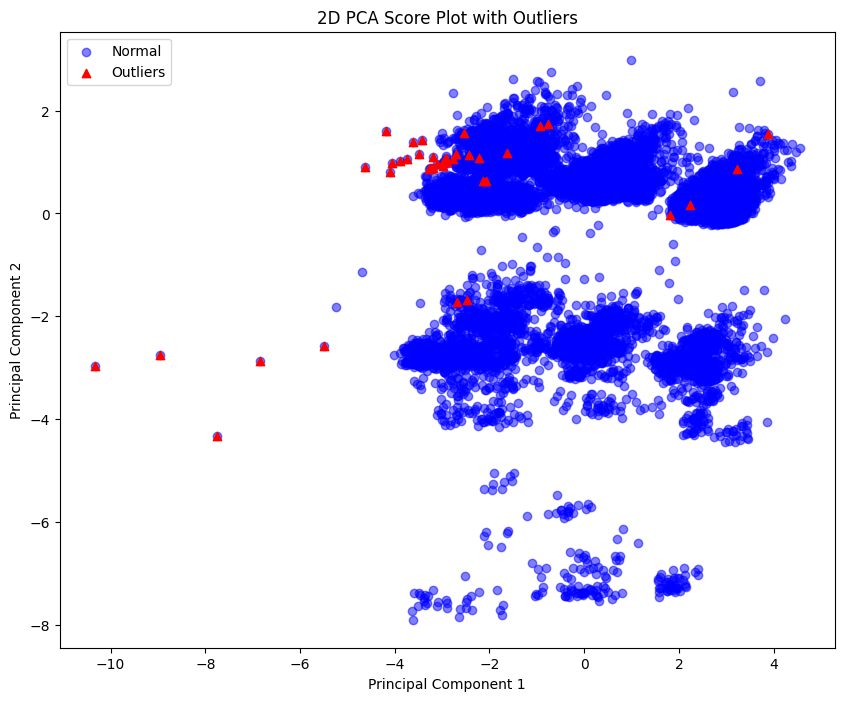

Number of detected outliers: 41
Detected outliers indices: [ 1306  1307  1308  1309  2690  2691  6167  6168  6501  6502  6503  8292
  8293  8294  9076 10516 10517 10518 10814 10815 12548 12549 12550 13871
 13872 14793 16865 16866 18166 18168 18218 18219 18565 18566 18567 18705
 18706 18707 18708 20149 20173]


In [114]:
from mpl_toolkits.mplot3d import Axes3D

# Assuming X_scaled and pca from the previous cell are available

# Reconstruct the data from the PCA components
X_reconstructed = pca.inverse_transform(X_pca)

# Calculate reconstruction errors by comparing original scaled data with reconstructed data
reconstruction_error = np.mean(np.square(X_scaled - X_reconstructed), axis=1)

# Set a threshold for the reconstruction error
threshold = np.mean(reconstruction_error) + 2 * np.std(reconstruction_error) # A common approach: mean + 2 std dev

# Identify outliers
outliers = np.where(reconstruction_error > threshold)[0]

# Visual Inspection of PCA Score Plots in 2D
# Use X_pca directly for plotting, no need to fit_transform again
pca_scores = X_pca # X_pca is already the PCA scores

# Select the first 2 components for 2D plotting
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111) # Removed projection='3d' for 2D plot

# Plot normal points and outliers using the first 2 principal components
ax.scatter(pca_scores[:, 0], pca_scores[:, 1], c='b', marker='o', alpha=0.5, label='Normal')
ax.scatter(pca_scores[outliers, 0], pca_scores[outliers, 1], c='r', marker='^', label='Outliers')

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('2D PCA Score Plot with Outliers')
ax.legend()

plt.show()

# Print the indices of detected outliers
print(f'Number of detected outliers: {outliers.shape[0]}')
print(f'Detected outliers indices: {outliers}')

In [115]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Get the data for stop 18 from df2
df_stop18 = df2['stop_18'].copy()

# Remove rows identified as outliers
# Ensure the indices align - outliers indices are relative to the original df_stop18
# Re-calculate outliers specifically for df_stop18 if PCA was done on a different subset
# Assuming PCA was done on df_stop18 for simplicity based on previous cell context
# If PCA was done on a different dataframe, the outlier indices would need adjustment.
# For now, let's assume the 'outliers' indices are relative to df_stop18.
df_stop18_cleaned = df_stop18.drop(index=df_stop18.index[outliers])


# Drop non-predictive columns
df_stop18_cleaned = df_stop18_cleaned.drop(['Calendar_date', 'stop_sequence'], axis=1)

# Define features and target
X_stop18 = df_stop18_cleaned.drop(['arrival_delay_stop_20'], axis=1)
y_stop18 = df_stop18_cleaned['arrival_delay_stop_20']

# Split chronologically: first 80% train, last 20% test
split_idx = int(len(X_stop18) * 0.8)
X_train_stop18, X_test_stop18 = X_stop18.iloc[:split_idx], X_stop18.iloc[split_idx:]
y_train_stop18, y_test_stop18 = y_stop18.iloc[:split_idx], y_stop18.iloc[split_idx:]

# Standardize features
scaler_stop18 = StandardScaler()
X_train_scaled_stop18 = scaler_stop18.fit_transform(X_train_stop18)
X_test_scaled_stop18 = scaler_stop18.transform(X_test_stop18)

# Train Linear Regression model
model_stop18_cleaned = LinearRegression()
model_stop18_cleaned.fit(X_train_scaled_stop18, y_train_stop18)

# Evaluate
y_pred_stop18 = model_stop18_cleaned.predict(X_test_scaled_stop18)
r2_stop18 = r2_score(y_test_stop18, y_pred_stop18)
mae_stop18 = mean_absolute_error(y_test_stop18, y_pred_stop18)
mse_stop18 = mean_squared_error(y_test_stop18, y_pred_stop18)


print(f"Metrics for Stop Sequence 18 (after outlier removal):")
print(f"Mean Absolute Error: {mae_stop18}")
print(f"Mean Squared Error: {mse_stop18}")
print(f"R-squared: {r2_stop18}")

Metrics for Stop Sequence 18 (after outlier removal):
Mean Absolute Error: 24.507680304847423
Mean Squared Error: 1017.4081340216172
R-squared: 0.983677693001169


### **PLAYING AROUND**

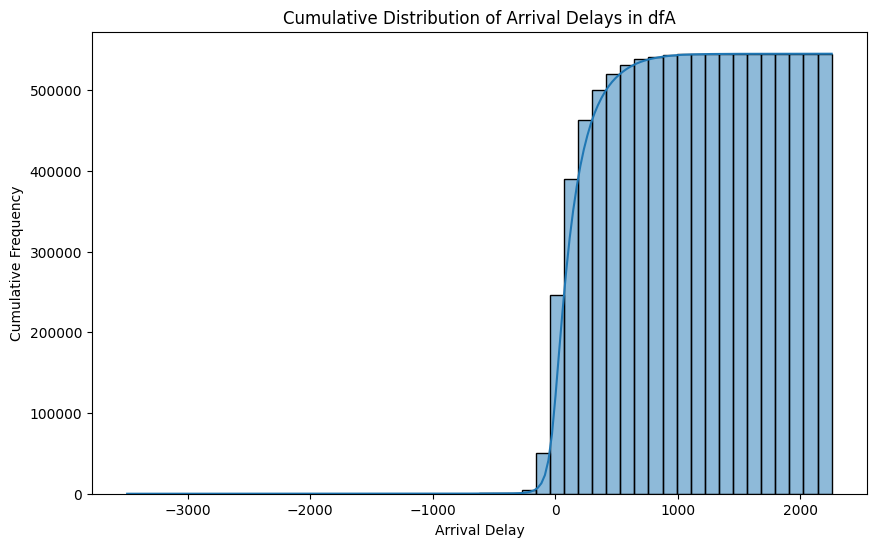

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(data=dfA, x='arrival_delay', kde=True, cumulative=True, bins=50)
plt.title('Cumulative Distribution of Arrival Delays in dfA')
plt.xlabel('Arrival Delay')
plt.ylabel('Cumulative Frequency')
plt.show()

### **MODEL 5 Neural Network**
I will try to model a neural network on the data proposed in model 2 so only one stop train and testing then I will compare results and see if it's valuable to model more NN for other stops.

In [119]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Data definition
X_train_scaled=test_train2['stop_13']['X_train_scaled']
X_test_scaled=test_train2['stop_13']['X_test_scaled']
y_train=test_train2['stop_13']['y_train']
y_test=test_train2['stop_13']['y_test']

model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(16, activation='relu'),
    Dense(1)
])

model.compile(optimizer=Adam(1e-4), loss='mae', metrics=['mae'])

early_stop = EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=3)

history = model.fit(X_train_scaled, y_train,
          validation_data=(X_test_scaled, y_test),
          epochs=50, batch_size=32,
          callbacks=[early_stop, reduce_lr])

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


505/505 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 181.6587 - mae: 181.6587 - val_loss: 234.7489 - val_mae: 234.7489 - learning_rate: 1.0000e-04
Epoch 2/50
505/505 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 181.4561 - mae: 181.4561 - val_loss: 231.6319 - val_mae: 231.6319 - learning_rate: 1.0000e-04
Epoch 3/50
505/505 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 178.1279 - mae: 178.1279 - val_loss: 225.7293 - val_mae: 225.7293 - learning_rate: 1.0000e-04
Epoch 4/50
505/505 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 173.6870 - mae: 173.6870 - val_loss: 216.2462 - val_mae: 216.2462 - learning_rate: 1.0000e-04
Epoch 5/50
505/505 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 163.0017 - mae: 163.0017 - val_loss: 202.8270 - val_mae: 202.8270 - learning_rate: 1.0000e-04
Epoch 6/50
505/505 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 154.1404 - mae: 154.1404 - val_loss: 186.9870 - val_mae: 186.9870 - learning_rate: 1.0000e-04
Epoch 7/50
505/505 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 141.8504 - mae: 141.8504 - 

In [120]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 32)             │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,461 (13.52 KB)

 Trainable params: 1,153 (4.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,308 (9.02 KB)

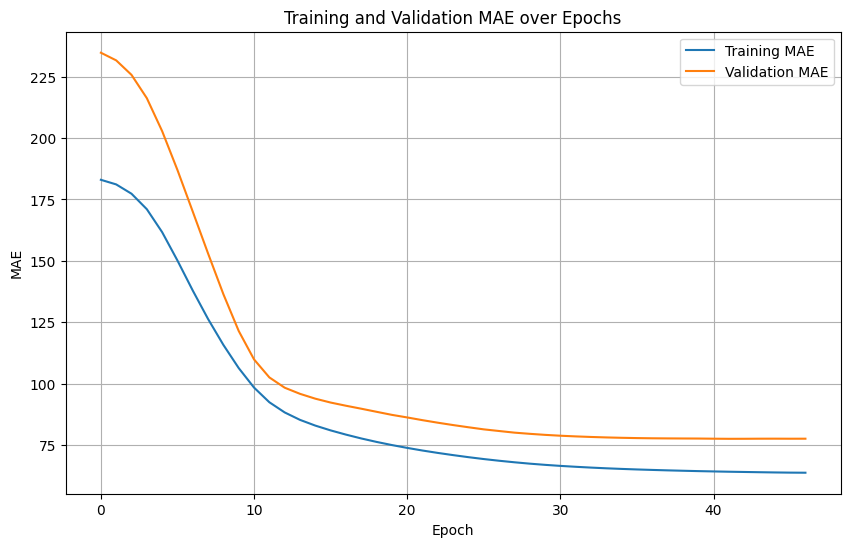

In [121]:
# Plot training and validation MAE over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()

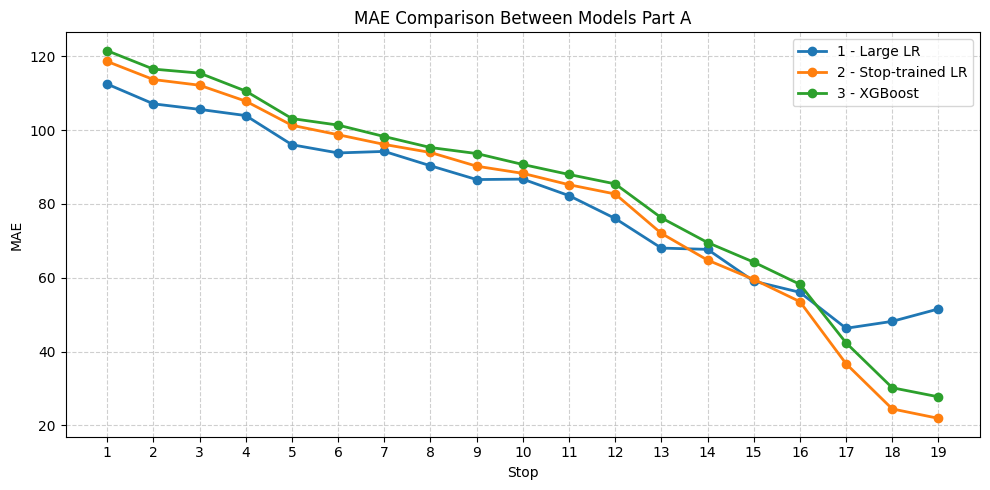

In [128]:
import matplotlib.pyplot as plt

# --- Extract MAE values ---
stops = list(range(1, 20))
mae1 = evaluation_df['MAE'].to_list()
mae3 = [v['MAE'] for v in results3.values()]
mae2 = [v['MAE'] for v in results2.values()]

# --- Plot ---
plt.figure(figsize=(10,5))
plt.plot(stops, mae1, marker='o', label='1 - Large LR', linewidth=2)
plt.plot(stops, mae2[:19], marker='o', label='2 - Stop-trained LR', linewidth=2)
plt.plot(stops, mae3[:19], marker='o', label='3 - XGBoost', linewidth=2)

plt.xticks(stops)  # force integer ticks on x-axis
plt.xlabel('Stop')
plt.ylabel('MAE')
plt.title('MAE Comparison Between Models Part A')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


## PART B
In this part I will have the entire dataset to create my models, including the previously discarded variables that are captured in real-time, i.e: `upstream_stop_delay`, `previous_bus_delay`, `previous_trip_travel_time`, `recurrent_delay` and `travel_time_for_previous_section`.
I will then assign the correspondent arrival delay for stop 20 to each row related to the same trip.


In [12]:
dfB=df.copy()

In [13]:
# Filter for rows where stop_sequence is 20
delay_at_stop_20_B = dfB[dfB['stop_sequence'] == 20][['Calendar_date', 'trip_number', 'arrival_delay']]

# Rename the 'arrival_delay' column to indicate it's the delay at stop 20
delay_at_stop_20_B = delay_at_stop_20_B.rename(columns={'arrival_delay': 'arrival_delay_stop_20'})

# Merge this information back into dfA_clean
dfB = pd.merge(dfB, delay_at_stop_20_B, on=['Calendar_date', 'trip_number'], how='left')

# Display the updated DataFrame
dfB

,Calendar_date,route_id,bus_id,stop_sequence,arrival_delay,dwell_time,travel_time_for_previous_section,scheduled_travel_time,upstream_stop_delay,origin_delay,...,factor(temperature)Cold,factor(temperature)Extra_cold,factor(temperature)Normal,factor(day_of_week)weekday,factor(day_of_week)weekend,factor(time_of_day)Afternoon_peak,factor(time_of_day)Morning_peak,factor(time_of_day)Off-peak,trip_number,arrival_delay_stop_20
0,20220108,4,41344,1,151,0,0,120,100,100,...,0,0,1,0,1,0,0,1,1,419
1,20220108,4,41344,2,185,24,171,45,151,100,...,0,0,1,0,1,0,0,1,1,419
2,20220108,4,41344,3,186,0,55,41,185,100,...,0,0,1,0,1,0,0,1,1,419
3,20220108,4,41344,4,202,12,42,94,186,100,...,0,0,1,0,1,0,0,1,1,419
4,20220108,4,41344,5,242,21,98,86,202,100,...,0,0,1,0,1,0,0,1,1,419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545098,20220630,4,41362,23,344,13,74,44,341,12,...,0,0,1,1,0,0,0,1,50,274
545099,20220630,4,41362,24,330,15,34,92,344,12,...,0,0,1,1,0,0,0,1,50,274
545100,20220630,4,41362,25,339,17,63,43,330,12,...,0,0,1,1,0,0,0,1,50,274
545101,20220630,4,41362,26,331,0,35,58,339,12,...,0,0,1,1,0,0,0,1,50,274


### **MODEL 6 Linear Regression**
With this model I aim at trying the same method as the one tested in model 2 with the complete features set

In [129]:
# Dropping the redundant
dfB_model6=dfB.drop(['route_id', 'bus_id', 'weather', 'temperature', 'day_of_week',
       'time_of_day', 'trip_number'], axis=1)

In [130]:
df6 = {}
models6 = {}
test_train6={}
results6 = {}

for i in range(1, 21):
    # Filter data for this stop
    dfB_model6_i = dfB_model6[dfB_model6['stop_sequence'] == i].copy()
    df6[f'stop_{i}'] = dfB_model6_i

    # Drop non-predictive columns
    dfB_model6_i = dfB_model6_i.drop(['Calendar_date', 'stop_sequence'], axis=1)

    # Define features and target
    X = dfB_model6_i.drop(['arrival_delay_stop_20'], axis=1)
    y = dfB_model6_i['arrival_delay_stop_20']

    # Split chronologically: first 80% train, last 20% test
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    test_train6[f'stop_{i}'] = {'X_train_scaled': X_train_scaled, 'X_test_scaled': X_test_scaled, 'y_train': y_train, 'y_test': y_test}

    # Train model
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)

    # Evaluate on the test set
    y_pred = model.predict(X_test_scaled)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    # Store results
    models6[f'model_stop_{i}'] = model
    results6[f'stop_{i}'] = {'R2': r2, 'MAE': mae, 'MSE': mse}

# Display performance summary
pd.DataFrame(results6).T



,R2,MAE,MSE
stop_1,0.635686,1.183095e+02,2.426429e+04
stop_2,0.676928,1.128753e+02,2.151749e+04
stop_3,0.687007,1.113739e+02,2.084616e+04
stop_4,0.709861,1.073132e+02,1.932405e+04
stop_5,0.745468,1.003843e+02,1.695255e+04
stop_6,0.758557,9.796367e+01,1.608074e+04
stop_7,0.772918,9.537137e+01,1.512425e+04
stop_8,0.783640,9.318505e+01,1.441018e+04
stop_9,0.800326,8.892460e+01,1.329886e+04
stop_10,0.802784,8.790307e+01,1.313515e+04


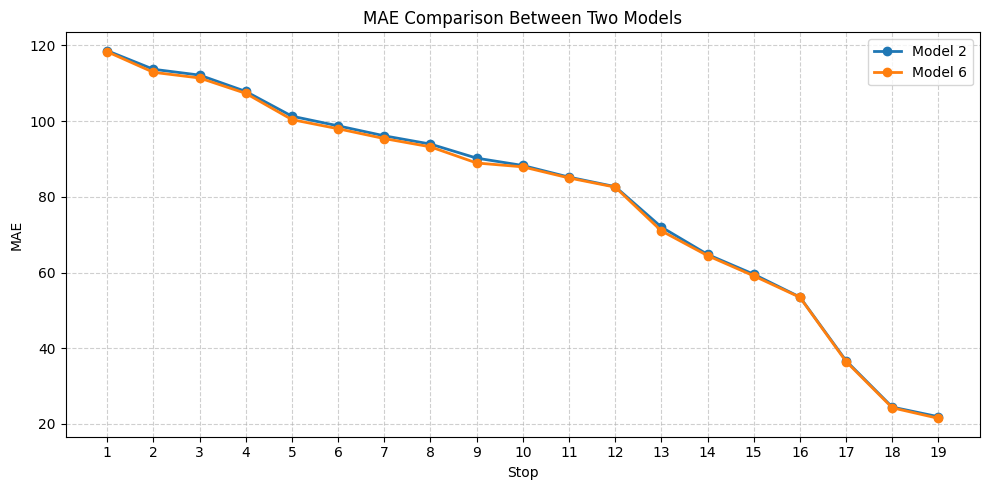

In [134]:
import matplotlib.pyplot as plt

# --- Extract MAE values ---
stops = list(range(1,20))
mae2 = [v['MAE'] for v in results2.values()]
mae6 = [v['MAE'] for v in results6.values()]

# --- Plot ---
plt.figure(figsize=(10,5))
plt.plot(stops, mae2[:19], marker='o', label='Model 2', linewidth=2)
plt.plot(stops, mae6[:19], marker='o', label='Model 6', linewidth=2)
plt.xticks(stops)
plt.xlabel('Stop')
plt.ylabel('MAE')
plt.title('MAE Comparison Between Two Models')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
ù
# Get the coefficients and the feature names
coefficients = models6['model_stop_18'].coef_
feature_names = X_train.columns

# Create a pandas Series to easily view coefficients with their feature names
coefficients_series = pd.Series(coefficients, index=feature_names)

# Sort the coefficients by their absolute value to see the most influential features
sorted_coefficients = coefficients_series.abs().sort_values(ascending=False)

print("Model Coefficients (sorted by absolute value):")
display(coefficients_series[sorted_coefficients.index])

Model Coefficients (sorted by absolute value):


,0
arrival_delay,182.348805
scheduled_travel_time,-11.197028
upstream_stop_delay,10.945378
factor(time_of_day)Morning_peak,-6.388842
recurrent_delay,4.419038
factor(time_of_day)Off-peak,3.890501
factor(day_of_week)weekend,-3.734688
factor(day_of_week)weekday,3.734688
origin_delay,-3.140828
dwell_time,1.955424


We can see that the prediction hasn't improved much, apparently the added features don't matter too much for our regression and it is understandable because knowing the previous stop's delay doesn't help too much to discover patterns about a stop that is kms away.
To clarify I'm trying to discover delay at stop 20 from say stop 13, in model 2 we had the delay at stop 13 while in model 6 we have the delays at stop 12 and 13, with a linear regression this is not too helpful but we can try something else.

### **MODEL 7 Clustering**
I plan to modify the data provided to have timeseries that show the delay fluctuation at different stops, after which I will use the data provided and try to estimate the delay from the two delays that we have: `arrival_delay`and `upstream_stop_delay`



In [14]:
dfB_model7=dfB.copy()

In [15]:
dfB_model7.head(40)

,Calendar_date,route_id,bus_id,stop_sequence,arrival_delay,dwell_time,travel_time_for_previous_section,scheduled_travel_time,upstream_stop_delay,origin_delay,...,factor(temperature)Cold,factor(temperature)Extra_cold,factor(temperature)Normal,factor(day_of_week)weekday,factor(day_of_week)weekend,factor(time_of_day)Afternoon_peak,factor(time_of_day)Morning_peak,factor(time_of_day)Off-peak,trip_number,arrival_delay_stop_20
0,20220108,4,41344,1,151,0,0,120,100,100,...,0,0,1,0,1,0,0,1,1,419
1,20220108,4,41344,2,185,24,171,45,151,100,...,0,0,1,0,1,0,0,1,1,419
2,20220108,4,41344,3,186,0,55,41,185,100,...,0,0,1,0,1,0,0,1,1,419
3,20220108,4,41344,4,202,12,42,94,186,100,...,0,0,1,0,1,0,0,1,1,419
4,20220108,4,41344,5,242,21,98,86,202,100,...,0,0,1,0,1,0,0,1,1,419
5,20220108,4,41344,6,260,13,105,38,242,100,...,0,0,1,0,1,0,0,1,1,419
6,20220108,4,41344,7,278,12,43,79,260,100,...,0,0,1,0,1,0,0,1,1,419
7,20220108,4,41344,8,272,8,85,97,278,100,...,0,0,1,0,1,0,0,1,1,419
8,20220108,4,41344,9,292,24,83,47,272,100,...,0,0,1,0,1,0,0,1,1,419
9,20220108,4,41344,10,351,9,43,85,292,100,...,0,0,1,0,1,0,0,1,1,419


In [16]:
# Separating the df to not leak any data
dfB_model7_train=dfB_model7[dfB_model7['Calendar_date']<20220600]
dfB_model7_test=dfB_model7[dfB_model7['Calendar_date']>=20220600]

In [17]:
# Define number of stops
n_stops = 27
# Find number of total trips
n_rows = len(dfB_model7_test)
n_trips = int(n_rows / n_stops)

# Extracting the delays
arrival_delays = dfB_model7_test['arrival_delay'].values

# --- Option 1: each row = one trip, each column = one stop ---
vectorized_delays = arrival_delays.reshape(n_trips, n_stops)

# --- Option 2: transpose if you prefer stops as rows ---
# vectorized_delays = delays.reshape(n_trips, n_stops).T

print(vectorized_delays.shape)


(2600, 27)


In [113]:
# normalize each trip (row-wise)
scaler = StandardScaler()
vectorized_delays_scaled = scaler.fit_transform(vectorized_delays)

from sklearn.cluster import KMeans

n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
labels = kmeans.fit_predict(vectorized_delays)

print(np.bincount(labels))

[ 437 1020   75  823    1  244]


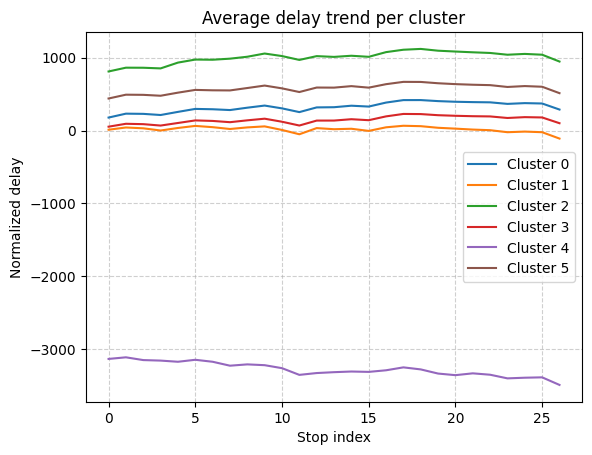

In [114]:
import matplotlib.pyplot as plt
import numpy as np

n_clusters = len(np.unique(labels))
for c in range(n_clusters):
    cluster_mean = np.nanmean(vectorized_delays[labels == c], axis=0)
    plt.plot(cluster_mean, label=f'Cluster {c}')
plt.xlabel('Stop index')
plt.ylabel('Normalized delay')
plt.title('Average delay trend per cluster')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


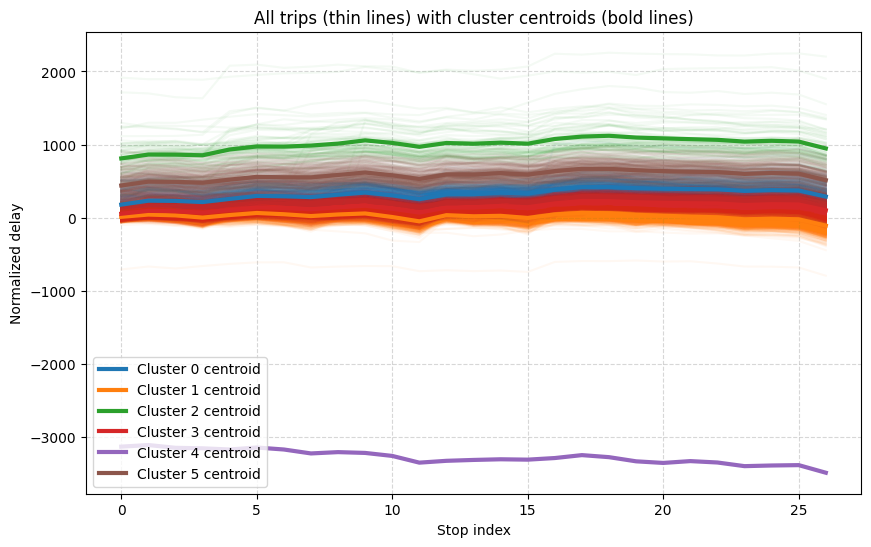

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# --- Assume your data matrix ---
# vectorized_delays: shape (n_trips, n_stops)

# Normalize each trip so shapes are comparable
vectorized_delays_norm = (vectorized_delays - vectorized_delays.mean(axis=1, keepdims=True)) / (
    vectorized_delays.std(axis=1, keepdims=True) + 1e-8
)


# --- KMeans clustering ---
n_clusters = 6  # adjust as needed
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
labels = kmeans.fit_predict(vectorized_delays)

# --- Plot all trips with cluster centroids ---
plt.figure(figsize=(10, 6))

# Plot all trips, colored by cluster
for c in range(n_clusters):
    cluster_data = vectorized_delays[labels == c]
    plt.plot(cluster_data.T, color=f"C{c}", alpha=0.05)  # faint lines for individual trips

# Overlay the cluster centroids (mean trend)
for c in range(n_clusters):
    centroid = kmeans.cluster_centers_[c]
    plt.plot(centroid, color=f"C{c}", linewidth=3, label=f'Cluster {c} centroid')

plt.xlabel("Stop index")
plt.ylabel("Normalized delay")
plt.title("All trips (thin lines) with cluster centroids (bold lines)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


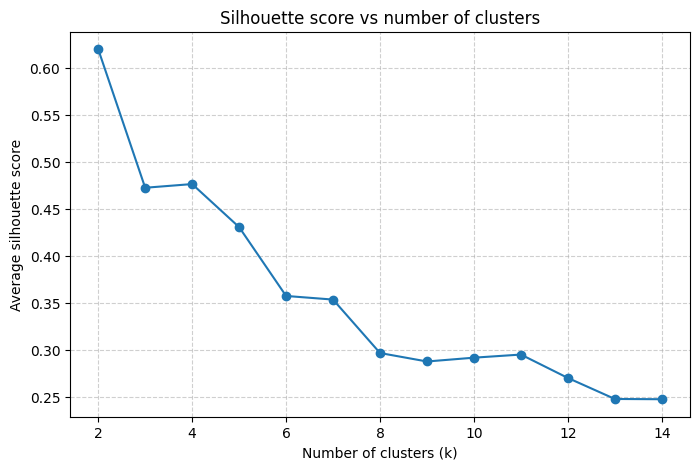

Best k based on silhouette score: 2 (score = 0.620)


In [32]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# Assume you already have this:
# vectorized_delays_norm = normalized (n_trips x n_stops)

sil_scores = []
K = range(2, 15)  # try cluster counts from 2 to 9

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(vectorized_delays)
    score = silhouette_score(vectorized_delays, labels)
    sil_scores.append(score)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(K, sil_scores, marker='o')
plt.title("Silhouette score vs number of clusters")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Average silhouette score")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

best_k = K[np.argmax(sil_scores)]
print(f"Best k based on silhouette score: {best_k} (score = {max(sil_scores):.3f})")


In [101]:
import numpy as np

# Assume you have your matrix of shape (n_trips, n_stops)
# vectorized_delays = e.g. delays in seconds

# Subtract the first stop’s delay (per trip)
vectorized_delays_shifted = vectorized_delays - vectorized_delays[:, [0]]

print(vectorized_delays_shifted.shape)
print(vectorized_delays_shifted[:3])  # check first few rows


(2600, 27)
[[   0   41   18   -5   24   75   68   27   25   52    0  -56  -36  -62
   -64  -39  -20  -14  -11  -39    1  -16  -12   -9   39   29  -42]
 [   0   31   26   -5   -2   36   11   -8   -6   -8  -62 -119  -25  -53
   -60  -90  -17   -1  -31  -53  -53  -69  -89 -107  -82  -82 -159]
 [   0   69   67   54   65   90   92   84  131  136  154   89   97  100
   139  128  155  226  227  190  200  178  178  163  162  165  112]]


In [46]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

# -----------------------------
# 1. Cluster the training trips
# -----------------------------
n_clusters = [2,5,8,11,14]
clustering_results={}
for n_clusterss in n_clusters:
  kmeans = KMeans(n_clusters=n_clusterss, random_state=42, n_init=10)
  labels_train = kmeans.fit_predict(vectorized_delays)

  # -----------------------------
  # 2. Compute centroids (absolute delays)
  # -----------------------------
  centroids = []
  n_stops = vectorized_delays.shape[1]

  for c in range(n_clusterss):
      cluster_trips = vectorized_delays[labels_train == c]
      centroid = np.nanmean(cluster_trips, axis=0)  # shape (n_stops,)
      centroids.append(centroid.reshape(1, -1))     # shape (1, n_stops)

  # -----------------------------
  # 3. Predict next stop for each row in dfB_model7_test
  # -----------------------------

  use_origin = False  # set True if you want origin_delay

  stop_mae = []
  stop_mape = []

  # unique stops in your dataset, limited to stop 20
  stops = sorted(dfB_model7_test['stop_sequence'].unique())[:20]
  n_stops = vectorized_delays.shape[1]  # for centroid indexing

  for stop in stops:
      # rows for this stop
      df_stop = dfB_model7_test[dfB_model7_test['stop_sequence'] == stop].copy()

      closest_centroid_indices = []
      predicted_next = []

      for idx, row in df_stop.iterrows():
          stop_idx = int(row['stop_sequence']) - 1

          # Skip if next stop is out of bounds
          if stop_idx >= n_stops - 1:
              closest_centroid_indices.append(np.nan)
              predicted_next.append(np.nan)
              continue

          # Observed vector
          if use_origin:
              observed = np.array([
                  row['upstream_stop_delay'],
                  row['arrival_delay'],
                  row['origin_delay']
              ]).reshape(1, -1)
          else:
              observed = np.array([
                  row['upstream_stop_delay'],
                  row['arrival_delay']
              ]).reshape(1, -1)

          # Compare to centroids
          distances = []
          for centroid in centroids:
              if use_origin:
                  centroid_vector = np.array([
                      centroid[0, stop_idx - 1],
                      centroid[0, stop_idx],
                      centroid[0, 0]
                  ]).reshape(1, -1)
              else:
                  centroid_vector = np.array([
                      centroid[0, stop_idx - 1],
                      centroid[0, stop_idx]
                  ]).reshape(1, -1)

              d = pairwise_distances(observed, centroid_vector, metric='euclidean')[0, 0]
              distances.append(d)

          # Closest centroid
          closest = np.argmin(distances)
          closest_centroid_indices.append(closest)

          # Predict stop 20
          predicted_delay = centroids[closest][0, 19]
          predicted_next.append(predicted_delay)

      # Add predictions to DataFrame
      df_stop['closest_centroid'] = closest_centroid_indices
      df_stop['predicted_next'] = predicted_next

      # Evaluate
      mask = ~df_stop['predicted_next'].isna()
      mae = np.mean(np.abs(df_stop.loc[mask, 'predicted_next'] - df_stop.loc[mask, 'arrival_delay']))
      mape = np.mean(np.abs((df_stop.loc[mask, 'predicted_next'] - df_stop.loc[mask, 'arrival_delay']) / df_stop.loc[mask, 'arrival_delay']))

      stop_mae.append(mae)
      stop_mape.append(mape)

  # Convert to DataFrame for easy plotting/comparison
  df_performance = pd.DataFrame({
      'stop_sequence': stops,
      'MAE': stop_mae,
      'MAPE': stop_mape
  })
  clustering_results[f'k_{n_clusterss}']=df_performance
  print(df_performance)

    stop_sequence         MAE  MAPE
0               1  134.989131   inf
1               2  114.905684   inf
2               3  121.053164   inf
3               4  136.510033   inf
4               5  114.603698   inf
5               6  101.147225   inf
6               7  108.223523   inf
7               8  120.079280   inf
8               9  111.493855   inf
9              10  109.900017   inf
10             11  125.955837   inf
11             12  156.701622   inf
12             13  113.496176   inf
13             14  117.974246   inf
14             15  115.545118   inf
15             16  127.702500   inf
16             17  113.564100   inf
17             18  115.037573   inf
18             19  116.572382   inf
19             20  120.210610   inf
    stop_sequence         MAE  MAPE
0               1  107.959852   inf
1               2   93.080086   inf
2               3   99.056555   inf
3               4  119.434314   inf
4               5   86.595455   inf
5               6   68.83261

In [47]:
clustering_results

{'k_2':     stop_sequence         MAE  MAPE
 0               1  134.989131   inf
 1               2  114.905684   inf
 2               3  121.053164   inf
 3               4  136.510033   inf
 4               5  114.603698   inf
 5               6  101.147225   inf
 6               7  108.223523   inf
 7               8  120.079280   inf
 8               9  111.493855   inf
 9              10  109.900017   inf
 10             11  125.955837   inf
 11             12  156.701622   inf
 12             13  113.496176   inf
 13             14  117.974246   inf
 14             15  115.545118   inf
 15             16  127.702500   inf
 16             17  113.564100   inf
 17             18  115.037573   inf
 18             19  116.572382   inf
 19             20  120.210610   inf,
 'k_5':     stop_sequence         MAE  MAPE
 0               1  107.959852   inf
 1               2   93.080086   inf
 2               3   99.056555   inf
 3               4  119.434314   inf
 4               5   86

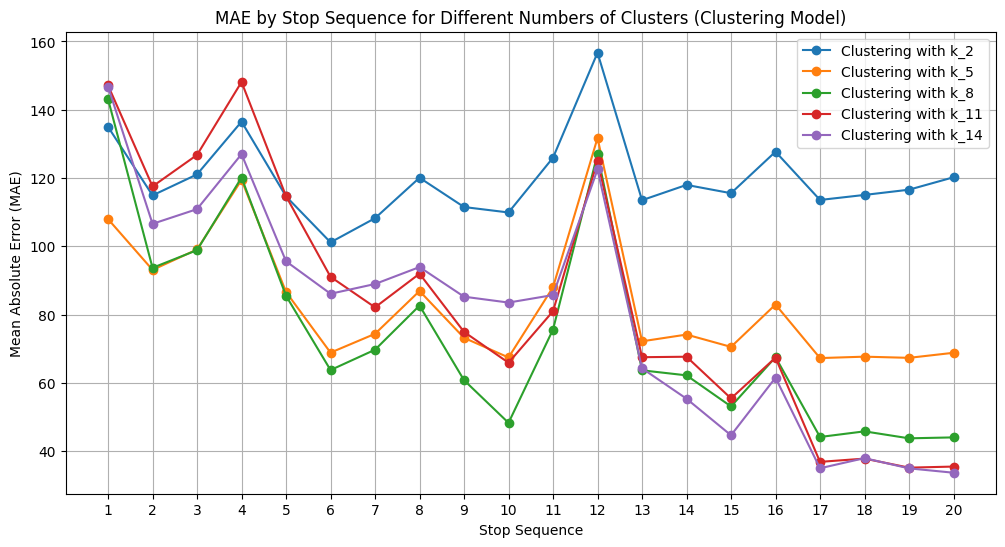

In [48]:
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(12, 6))

# Iterate through the clustering results dictionary and plot the MAE for each key (number of clusters)
for key, df_results in clustering_results.items():
    plt.plot(df_results['stop_sequence'], df_results['MAE'], marker='o', linestyle='-', label=f'Clustering with {key}')

plt.title('MAE by Stop Sequence for Different Numbers of Clusters (Clustering Model)')
plt.xlabel('Stop Sequence')
plt.ylabel('Mean Absolute Error (MAE)')
plt.xticks(df_performance['stop_sequence']) # Use stop sequences as x-ticks
plt.legend()
plt.grid(True)
plt.show()

### **MODEL 8 RNN**

In [147]:
dfB_model8=dfB.copy()

In [148]:
dfB_model8.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545103 entries, 0 to 545102
Data columns (total 33 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Calendar_date                      545103 non-null  int64  
 1   route_id                           545103 non-null  int64  
 2   bus_id                             545103 non-null  int64  
 3   stop_sequence                      545103 non-null  int64  
 4   arrival_delay                      545103 non-null  int64  
 5   dwell_time                         545103 non-null  int64  
 6   travel_time_for_previous_section   545103 non-null  int64  
 7   scheduled_travel_time              545103 non-null  int64  
 8   upstream_stop_delay                545103 non-null  int64  
 9   origin_delay                       545103 non-null  int64  
 10  previous_bus_delay                 545103 non-null  int64  
 11  previous_trip_travel_time          5451

In [149]:
# create a counter that increases every 27 rows
n_rows = len(dfB_model8)
dfB_model8['trip_id'] = np.arange(n_rows) // 27 + 1

In [150]:
dfB_model8

,Calendar_date,route_id,bus_id,stop_sequence,arrival_delay,dwell_time,travel_time_for_previous_section,scheduled_travel_time,upstream_stop_delay,origin_delay,...,factor(temperature)Extra_cold,factor(temperature)Normal,factor(day_of_week)weekday,factor(day_of_week)weekend,factor(time_of_day)Afternoon_peak,factor(time_of_day)Morning_peak,factor(time_of_day)Off-peak,trip_number,arrival_delay_stop_20,trip_id
0,20220108,4,41344,1,151,0,0,120,100,100,...,0,1,0,1,0,0,1,1,419,1
1,20220108,4,41344,2,185,24,171,45,151,100,...,0,1,0,1,0,0,1,1,419,1
2,20220108,4,41344,3,186,0,55,41,185,100,...,0,1,0,1,0,0,1,1,419,1
3,20220108,4,41344,4,202,12,42,94,186,100,...,0,1,0,1,0,0,1,1,419,1
4,20220108,4,41344,5,242,21,98,86,202,100,...,0,1,0,1,0,0,1,1,419,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545098,20220630,4,41362,23,344,13,74,44,341,12,...,0,1,1,0,0,0,1,50,274,20189
545099,20220630,4,41362,24,330,15,34,92,344,12,...,0,1,1,0,0,0,1,50,274,20189
545100,20220630,4,41362,25,339,17,63,43,330,12,...,0,1,1,0,0,0,1,50,274,20189
545101,20220630,4,41362,26,331,0,35,58,339,12,...,0,1,1,0,0,0,1,50,274,20189


In [152]:
dfB_model8.columns

Index(['Calendar_date', 'route_id', 'bus_id', 'stop_sequence', 'arrival_delay',
       'dwell_time', 'travel_time_for_previous_section',
       'scheduled_travel_time', 'upstream_stop_delay', 'origin_delay',
       'previous_bus_delay', 'previous_trip_travel_time', 'traffic_condition',
       'recurrent_delay', 'weather', 'temperature', 'day_of_week',
       'time_of_day', 'factor(weather)Light_Rain', 'factor(weather)Light_Snow',
       'factor(weather)Normal', 'factor(weather)Rain', 'factor(weather)Snow',
       'factor(temperature)Cold', 'factor(temperature)Extra_cold',
       'factor(temperature)Normal', 'factor(day_of_week)weekday',
       'factor(day_of_week)weekend', 'factor(time_of_day)Afternoon_peak',
       'factor(time_of_day)Morning_peak', 'factor(time_of_day)Off-peak',
       'trip_number', 'arrival_delay_stop_20', 'trip_id'],
      dtype='object')

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# -----------------------------
# 1. Define features and target
# -----------------------------
numeric_features = [
    'arrival_delay', 'upstream_stop_delay', 'origin_delay',
    'previous_bus_delay', 'previous_trip_travel_time', 'traffic_condition',
    'recurrent_delay', 'dwell_time', 'travel_time_for_previous_section',
    'scheduled_travel_time'
]

one_hot_features = [
    'factor(weather)Light_Rain', 'factor(weather)Light_Snow', 'factor(weather)Normal',
    'factor(weather)Rain', 'factor(weather)Snow',
    'factor(temperature)Cold', 'factor(temperature)Extra_cold', 'factor(temperature)Normal',
    'factor(day_of_week)weekday', 'factor(day_of_week)weekend',
    'factor(time_of_day)Afternoon_peak', 'factor(time_of_day)Morning_peak', 'factor(time_of_day)Off-peak'
]

feature_cols = numeric_features + one_hot_features

target_stop = 20  # predicting arrival_delay at stop 20

# -----------------------------
# 2. Prepare sequences per trip
# -----------------------------
trip_ids = df['trip_id'].unique()
n_trips = len(trip_ids)
n_stops = df['stop_sequence'].max()
n_features = len(feature_cols)

# Initialize input and target arrays
X = np.zeros((n_trips, n_stops, n_features))
y = np.zeros((n_trips, 1))  # stop 20 delay

for i, trip in enumerate(trip_ids):
    trip_df = df[df['trip_id'] == trip].sort_values('stop_sequence')
    X[i, :, :] = trip_df[feature_cols].values
    # Target: arrival_delay at stop 20
    y[i, 0] = trip_df[trip_df['stop_sequence'] == target_stop]['arrival_delay'].values

# -----------------------------
# 3. Standardize numeric features
# -----------------------------
scaler = StandardScaler()
# Only standardize numeric features, leave one-hot as-is
for f_idx, col in enumerate(feature_cols):
    if col in numeric_features:
        X[:, :, f_idx] = scaler.fit_transform(X[:, :, f_idx])

# -----------------------------
# 4. Train / validation split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -----------------------------
# 5. Define LSTM model
# -----------------------------
model = Sequential([
    LSTM(64, activation='tanh', input_shape=(n_stops, n_features)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)  # regression output: stop 20 delay
])

model.compile(optimizer=Adam(1e-3), loss='mae', metrics=['mae'])

# -----------------------------
# 6. Train the model
# -----------------------------
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    verbose=1
)

# -----------------------------
# 7. Evaluate
# -----------------------------
y_pred = model.predict(X_val)
mae = np.mean(np.abs(y_pred - y_val))
print("Validation MAE for stop 20:", mae)


In [156]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# -----------------------------
# 1. Define features
# -----------------------------
numeric_features = [
    'arrival_delay', 'upstream_stop_delay', 'origin_delay',
    'previous_bus_delay', 'previous_trip_travel_time', 'traffic_condition',
    'recurrent_delay', 'dwell_time', 'travel_time_for_previous_section',
    'scheduled_travel_time'
]

one_hot_features = [
    'factor(weather)Light_Rain', 'factor(weather)Light_Snow', 'factor(weather)Normal',
    'factor(weather)Rain', 'factor(weather)Snow',
    'factor(temperature)Cold', 'factor(temperature)Extra_cold', 'factor(temperature)Normal',
    'factor(day_of_week)weekday', 'factor(day_of_week)weekend',
    'factor(time_of_day)Afternoon_peak', 'factor(time_of_day)Morning_peak', 'factor(time_of_day)Off-peak'
]

feature_cols = numeric_features + one_hot_features
target_stop = 20

# -----------------------------
# 2. Get unique trips and stops
# -----------------------------
trip_ids = dfB_model8['trip_id'].unique()
max_stop = dfB_model8['stop_sequence'].max()
n_features = len(feature_cols)

# -----------------------------
# 3. Prepare sequences per trip up to stop n
# -----------------------------
# We'll store MAE per stop
stop_mae = []

for stop_n in range(1, target_stop):
    print(f"Processing stop {stop_n}...")

    X_list = []
    y_list = []

    for trip in trip_ids:
        trip_df = dfB_model8[dfB_model8['trip_id'] == trip].sort_values('stop_sequence')
        # Take stops 1 -> stop_n as input
        seq_df = trip_df[trip_df['stop_sequence'] <= stop_n]
        X_seq = seq_df[feature_cols].values  # shape (stop_n, n_features)

        # Target: arrival_delay at stop 20
        y_val = trip_df[trip_df['stop_sequence'] == target_stop]['arrival_delay'].values
        if len(y_val) == 0:
            continue  # skip trips that don't reach stop 20
        y_val = y_val[0]

        X_list.append(X_seq)
        y_list.append(y_val)

    # Pad sequences to same length (needed for RNN)
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    X_padded = pad_sequences(X_list, dtype='float32', padding='pre', value=0.0)  # shape (n_trips, stop_n, n_features)
    y_array = np.array(y_list).reshape(-1, 1)

    # Standardize numeric features
    for f_idx, col in enumerate(feature_cols):
        if col in numeric_features:
            col_values = X_padded[:, :, f_idx].flatten()
            mean = col_values.mean()
            std = col_values.std() if col_values.std() > 0 else 1
            X_padded[:, :, f_idx] = (X_padded[:, :, f_idx] - mean) / std

    # Train/validation split
    X_train, X_val, y_train, y_val = train_test_split(X_padded, y_array, test_size=0.2, random_state=42)

    # -----------------------------
    # 4. Define RNN model
    # -----------------------------
    model = Sequential([
        LSTM(64, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)  # predict stop 20 delay
    ])

    model.compile(optimizer=Adam(1e-3), loss='mae', metrics=['mae'])

    # -----------------------------
    # 5. Train
    # -----------------------------
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=64, verbose=0)

    # -----------------------------
    # 6. Evaluate
    # -----------------------------
    y_pred = model.predict(X_val)
    mae_val = np.mean(np.abs(y_pred - y_val))
    stop_mae.append(mae_val)

# -----------------------------
# 7. Results
# -----------------------------
df_stop_mae = pd.DataFrame({
    'stop_sequence': range(1, target_stop),
    'MAE_for_stop20': stop_mae
})

print(df_stop_mae)


Processing stop 1...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Processing stop 2...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Processing stop 3...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Processing stop 4...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Processing stop 5...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Processing stop 6...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Processing stop 7...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Processing stop 8...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Processing stop 9...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Processing stop 10...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Processing stop 11...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Processing stop 12...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Processing stop 13...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Processing stop 14...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Processing stop 15...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Processing stop 16...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Processing stop 17...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Processing stop 18...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Processing stop 19...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
    stop_sequence  MAE_for_stop20
0               1      106.798444
1               2      102.753704
2               3      100.944753
3               4       96.578215
4               5       90.297743
5               6       87.514105
6               7       85.251194
7               8       82.842668
8               9       77.881274
9              10       75.184965
10             11       72.795100
11             12       70.569892
12             13       62.128558
13             14       57.029636
14             15       54.661293
15             16       48.394051
16             17       36.129359
17             18       21.587809
18             19       18.771187


In [ ]:
model.summary()

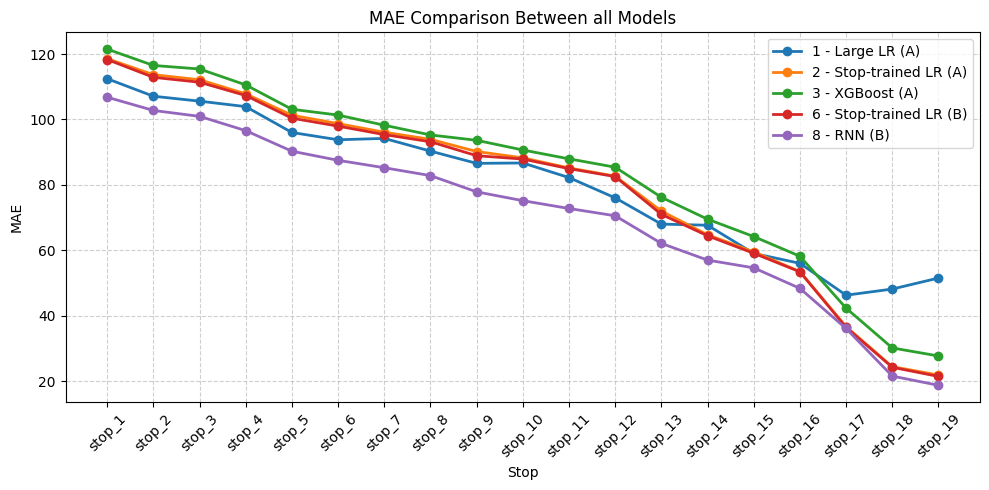

In [199]:
import matplotlib.pyplot as plt

# --- Extract MAE values ---
stops = list(results2.keys())
mae1=evaluation_df['MAE'].to_list()
mae3 = [v['MAE'] for v in results3.values()]
mae2 = [v['MAE'] for v in results2.values()]
mae6 = [v['MAE'] for v in results6.values()]
mae8 = (df_stop_mae['MAE_for_stop20'].to_list())

# --- Plot ---
plt.figure(figsize=(10,5))
plt.plot(stops[:19], mae1, marker='o', label='1 - Large LR (A)', linewidth=2)
plt.plot(stops[:19], mae2[:19], marker='o', label='2 - Stop-trained LR (A)', linewidth=2)
plt.plot(stops[:19], mae3[:19], marker='o', label='3 - XGBoost (A)', linewidth=2)
plt.plot(stops[:19], mae6[:19], marker='o', label='6 - Stop-trained LR (B)', linewidth=2)
plt.plot(stops[:19], mae8, marker='o', label='8 - RNN (B)', linewidth=2)
plt.xticks(rotation=45)
plt.xlabel('Stop')
plt.ylabel('MAE')
plt.title('MAE Comparison Between all Models')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
